Deep AR implementation on sales data

In [1]:
pip install mxnet-cu102

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.8/380.8 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [2]:
pip install "gluonts[mxnet]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.9 MB/s eta 0:00:00


In [3]:
# import all necessary libraries
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.model.n_beats import NBEATSEstimator
from gluonts.mx.trainer import Trainer
import numpy as np
import matplotlib as mb
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

/usr/local/lib/python3.9/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
<ipython-input-3-5a8f482e0d5a>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv

--2023-04-05 03:43:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317399 (310K) [application/x-httpd-php]
Saving to: ‘Sales_Transactions_Dataset_Weekly.csv’

Sales_Transactions_ 100%[===================>] 309.96K  1.10MB/s    in 0.3s    

2023-04-05 03:43:00 (1.10 MB/s) - ‘Sales_Transactions_Dataset_Weekly.csv’ saved [317399/317399]



In [5]:
#Load the data into data frame
Sales_Data=pd.read_csv("/content/Sales_Transactions_Dataset_Weekly.csv")

In [6]:
# remove extra columns
Sales_Data=Sales_Data.iloc[:,0:53]

In [7]:
Sales_Data

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0


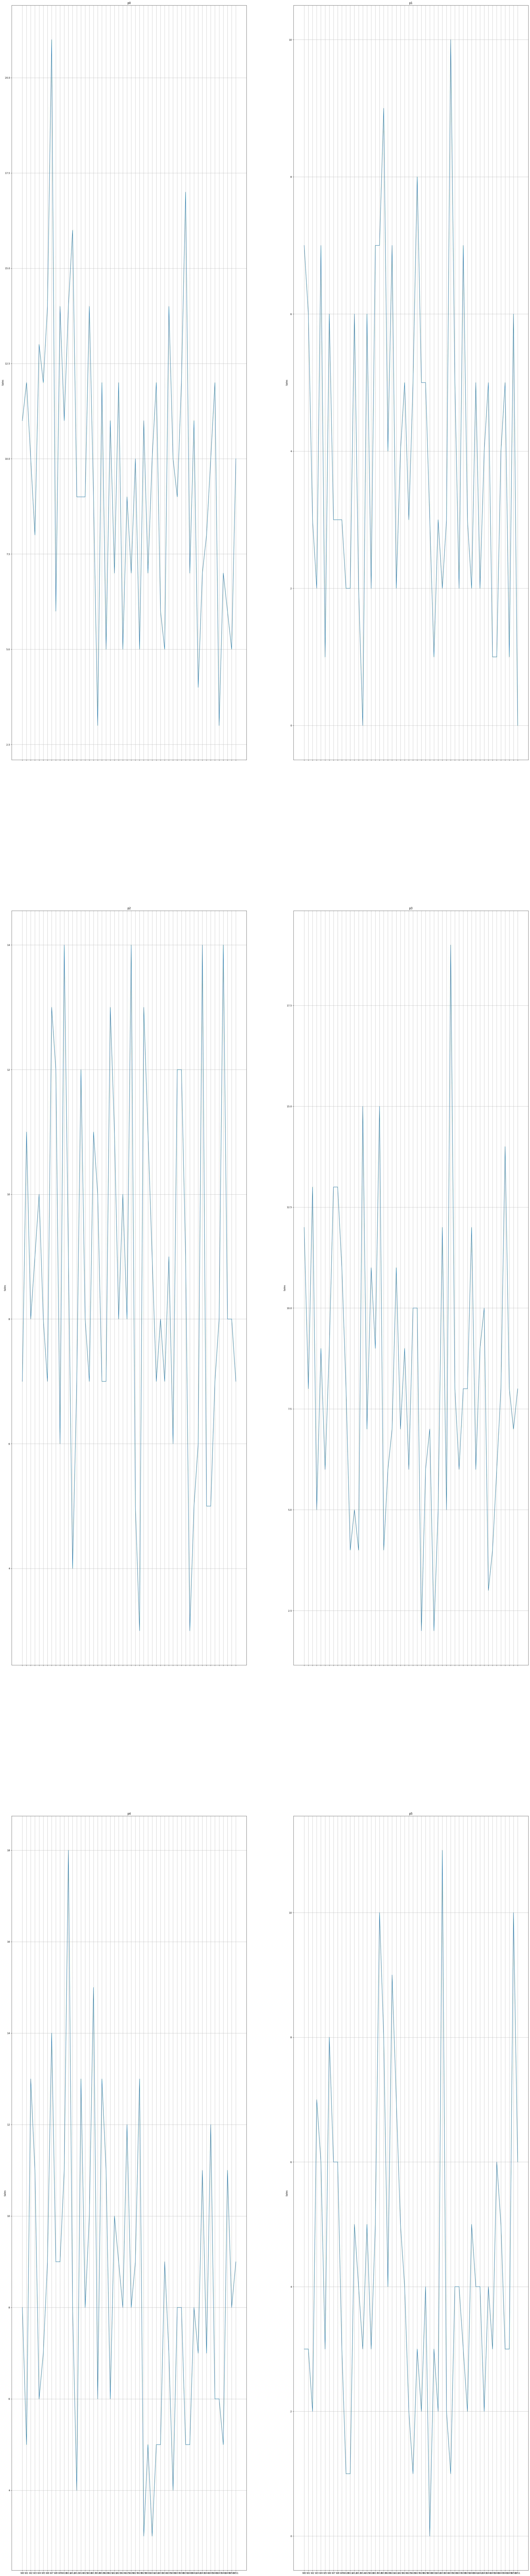

In [8]:
#plots of sample data for a custom range of prodct's time series
plt.rcParams["axes.grid"] = True
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(40,200),sharex=True)

axes_array=ax.ravel()
for i in range(0,6):
    axes_array[i].plot(Sales_Data.iloc[i,1:])
    axes_array[i].set(title=f'p{i}' , ylabel="Sales")
    axes_array[i].grid(which='minor',axis='x')

In [9]:
Sales_Data=Sales_Data.T.reset_index(drop=True).T

In [10]:
Sales_Data

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0


In [11]:
# In order to utilise house hold id's as feature static variable in GluonTS theses column was converted to codes for categorical feature processing.
Product_codes=Sales_Data.iloc[:,0].astype('category').cat.codes.values
Product_codes

array([  0, 111, 222, 331, 442, 553, 662, 769, 800,   1,  12,  23,  34,
        45,  56,  67,  78,  89, 100, 112, 123, 134, 145, 156, 167, 178,
       189, 200, 211, 223, 234, 245, 256, 267, 278, 288, 299, 310, 320,
       332, 343, 354, 365, 376, 387, 398, 409, 420, 431, 443, 454, 465,
       476, 487, 498, 509, 520, 531, 542, 554, 565, 576, 587, 598, 607,
       618, 629, 640, 651, 663, 673, 683, 692, 703, 714, 725, 736, 747,
       758, 770, 781, 792, 793, 794, 795, 796, 797, 798, 799, 801, 802,
       803, 804, 805, 806, 807, 808, 809, 810,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  90,  9

In [12]:
#split the data feame into test and train sets
Sales_train=Sales_Data.iloc[:,1:42].values
Sales_test=Sales_Data.iloc[:,42:].values

In [13]:
Sales_train.shape

(811, 41)

In [14]:
Sales_test.shape

(811, 11)

In [15]:
#split the data feame into test and train sets
freq="W"
start_train = pd.Timestamp("2014-01-01", freq=freq)
start_test = pd.Timestamp("2014-10-08", freq=freq)
prediction_lentgh=7

<ipython-input-15-4f3bef507f0f>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2014-01-01", freq=freq)
<ipython-input-15-4f3bef507f0f>:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2014-10-08", freq=freq)


In [16]:
estimator = DeepAREstimator(freq=freq, 
                            context_length=18,
                            prediction_length=prediction_lentgh,
                            use_feat_static_cat=True,
                            cardinality=[1],
                            num_layers=2,
                            num_cells=25,
                            cell_type='lstm',
                            trainer=Trainer(epochs=30, learning_rate=0.01))

In [17]:
# Convert the data into gluonts list dataset form to input the model
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(Sales_train,
                             Product_codes.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(Sales_test,
                            Product_codes.reshape(-1,1))
], freq=freq)

In [18]:
# train the estimator
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:02<00:00, 23.39it/s, epoch=30/30, avg_epoch_loss=1.41]


In [19]:
# Generation of predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=100, 
)

In [20]:
# Conversion of predictions to a list
print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(Sales_test))) 
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(Sales_test)))

Obtaining time series conditioning values ...


  0%|          | 0/811 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/811 [00:00<?, ?it/s]

In [21]:
# plot the predictions with probabilistic ranges ( provided in the official documentation of gluonTS )
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [22]:
#Utilise default library from gluonTS for evaluating the perfromance of the model
evaluator = Evaluator(quantiles=[0.80,0.90])
agg_metrics, item_metrics = evaluator(iter(tss),iter(forecasts),  num_series=len(tss))

Running evaluation: 100%|██████████| 811/811 [00:00<00:00, 18336.57it/s]
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [23]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,None,2014-11-03/2014-11-09,9.998162,17.283493,53.0,7.571429,3.666667,0.673383,0.354147,0.345774,0.326104,3.246807,14.000784,0.571429,7.632589,0.714286
1,None,2014-11-03/2014-11-09,5.828025,15.627634,18.0,2.571429,2.000000,1.116260,1.529447,0.913549,0.868202,6.218224,8.282413,1.000000,6.055706,1.000000
2,None,2014-11-03/2014-11-09,9.628726,15.648253,57.0,8.142857,6.000000,0.372577,0.251251,0.276393,0.274531,2.615025,13.055384,0.857143,12.007027,0.857143
3,None,2014-11-03/2014-11-09,12.844057,17.636740,55.0,7.857143,3.666667,0.687146,0.293174,0.331578,0.320668,7.299848,12.899599,0.857143,11.039798,0.857143
4,None,2014-11-03/2014-11-09,6.262161,16.134752,57.0,8.142857,3.000000,0.768322,0.293950,0.290147,0.283066,4.712651,8.545377,0.714286,4.975570,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,None,2014-11-03/2014-11-09,0.704027,3.028531,3.0,0.428571,0.333333,1.297942,0.995332,1.994691,1.009510,46.759804,4.743272,0.714286,5.246673,0.714286
807,None,2014-11-03/2014-11-09,2.554549,10.760114,32.0,4.571429,1.666667,0.922295,0.381588,0.382252,0.336254,5.433513,4.103492,0.857143,2.898028,0.857143
808,None,2014-11-03/2014-11-09,3.528257,10.758465,11.0,1.571429,1.000000,1.536924,0.856977,1.731127,0.978042,14.574137,12.429047,0.428571,10.403350,0.428571
809,None,2014-11-03/2014-11-09,0.880316,4.177812,4.0,0.571429,0.000000,inf,1.017953,2.000000,1.044453,inf,6.248987,0.285714,6.730914,0.571429


In [24]:
#Calculate RMSE Values
item_metrics['RMSE']=np.sqrt(item_metrics['MSE'])

In [25]:
# Calculation of NRMSE for each predicted time series
item_metrics['NRMSE']=item_metrics['RMSE']/item_metrics['abs_target_mean']

In [34]:
# number of time series with less than 0.5 nrmse for deep ar sales
sum(item_metrics['NRMSE']<0.5)

322

In [36]:
# number of time series with less than 0.5 nrmse
sum(item_metrics['NRMSE']>0.5)

489

In [28]:
# Calculation of normalised deviation for all time series
agg_metrics['ND']

0.3174796668916977

In [29]:
# Exporting the data to csv for further analysis in power bi.
item_metrics.to_csv('DeepAR_Sales_Results_Final.csv')